# Vocabulary Analysis

Man Ho Wong, University of Pittsburgh | April 24, 2022

*Jupyter notebooks are not always rendered properly on GitHub. Please [view this notebook here on nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/vocabulary_analysis.ipynb) if that happens.*

##### Script header

In [1]:
# Python libraries and packages required
from collections import Counter
from etc.pittchat import get_age_m as get_age_m      # get age in months
from gensim.models.keyedvectors import KeyedVectors  # For using word vectors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint                          # For pretty printing
import pylangacq                       # For reading CHAT files
import nltk
import networkx as nx                  # For contructing and analyzing networks
from sklearn import metrics as skm     # For pairwise cosine similarity
from sklearn.decomposition import PCA  # For dimention reduction

# For showing progress bar (optional)
#   This is useful for estimating the efficiency of the code.
from tqdm import tqdm

# Unpickle data
data_idx = pickle.load(open('../data/childes/data_idx_processed.pkl', 'rb'))

# Pretty printing for better readability:
# - print dict in compact format instead of one item per line
# - Items will be in alphabetical order; Counter in descending order
# - Nested Dict will be printed with suitable indentation
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# Function to get all labels of a given variable (e.g. 'mot_edu')
def get_labels(var):
    labels_by_corpus = {}
    corpus_set = set(data_idx.corpus)
    for c in corpus_set:
        labels_by_corpus[c] = set(data_idx[var][data_idx.corpus==c])
    return labels_by_corpus

---

# 1 Overview

> Data processing pipeline:  
>[`data_curation.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_curation.ipynb)  
>[`data_preprocessing.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_preprocessing.ipynb)  
>[`exploratory_analysis.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/exploratory_analysis.ipynb)  
>`vocabulary_analysis.ipynb` <-- You are here

This notebook is the last step of the data processing and analysis pipeline of the project. The goal here is to characterize lexical semantic networks during early vocabulary development across different socio-economic status (SES) groups.

### Table of contents

1. Overview
2. Semantic network: vocabulary analysis beyond mean length of utterance (MLU)
    - 2.1 Child vocabulary as a lexical semantic network
    - 2.2 Different metrics for word-to-word similarity
    - 2.3 Pipeline for constructing lexical semantic network
3. Semantic network analysis
    - 3.1 Characterizing semantic network
    - 3.2 Comparing children from different SES groups

---

# 2 Semantic network: vocabulary analysis beyond mean length of utterance (MLU)


## 2.1 Child vocabulary as a lexical semantic network

Why

References

## 2.2 Different metrics for word-to-word similarity

Relationships between words in a lexicon can be represented by how similar they are in their semantic meanings. There are many metrics to measure word-to-word similarity. In general, these metrics can be derived from two different sources: human-annotated datasets (e.g. WordNet), or word associations learned by machine algorithms (e.g. word2vec). Both sources have their pros and cons for different applications. In this project, I will use machine-generated word associations for the calculation of word-to-word similarity because it is more flexible (e.g. getting different word associations by using different training data) than human-annotated datasets and is probably less prone to human biases (depending on training data). Besides, human-annotated datasets are based on formal taxonomies of words and such knowledge is unlikely to be present in a young child's world.

There are two main types of machine-learning models to generate word associations, count-based and prediction-based models. In this project, word similarity will be computed from word embeddings based on a semantic network called **ConceptNet**, which is a network built by both count-based and prediction-based models. The most unique feature about ConceptNet is that, unlike other semantic networks, it is concept-based rather than word-based (though nodes are still represented by words or phrases). For mapping word relations in a young child's lexicon where word meanings are closely related to the concepts that they are acquiring at the same time, this concept-based feature probably makes ConceptNet more suitable for this project than word embeddings derived from other models.

## 2.3 Pipeline for constructing lexical semantic network

In this section, I will develop a pipeline for constructing lexical semantic network from each participant's word list in each CHAT file. This pipeline will be applied to all CHAT files in the dataset later. Below are the general steps:
1. Extract tokens from a CHAT file
2. Import ConceptNet-Numberbatch word vectors
3. Map each word in the word list to its word vector
4. Compute pairwise word similarity (cosine similarity) from word vectors
5. Construct a semantic network using cosine similarities as the weights of edges

### Step 1: Extract tokens from a CHAT file
I will use a CHAT file from the Brown Corpus to develop the pipeline, but instead of "Adam" I am going to use a file from "Eve" for a change. To streamline the process, I created a simple function, `get_vocab`, which allows me to get a `set` of unique words from a CHAT file with the option to specify word classes. This function can be accessed from `etc.pittchat` like other custom functions in this project.

In [2]:
# Read 'Eve' in Brown corpus into a reader object
path = '../data/data_samples/Brown.zip'
eve = pylangacq.Reader.from_zip(path, 'Eve')

In [3]:
# Get word list from the 3rd CHAT file in 'eve'
from etc.pittchat import get_vocab as get_vocab
vocab = get_vocab(eve[2], pos='n')  # get nouns only
cp.pprint(vocab)

{'arm', 'back', 'bacon', 'ball', 'banana', 'book', 'bowl', 'box', 'butter',
 'carrot', 'celery', 'cheese', 'coat', 'coffee', 'cracker', 'cup', 'dog',
 'door', 'drink', 'drop', 'feet', 'gopher', 'grahamcracker', 'grape', 'help',
 'hill', 'home', 'horse', 'horsie', 'juice', 'lady', 'lap', 'man', 'minute',
 'mommy', 'napkin', 'page', 'paper', 'pencil', 'picture', 'play', 'pudding',
 'right', 'self', 'shoe', 'soup', 'spoon', 'stool', 'sugar', 'swim', 'table',
 'tapioca', 'teddybear', 'toe', 'toy', 'train'}


I am extracting words here instead of morphemes because morphemes are annotated by adults and they do not necessarily represent lexical relationships in the child's mind. For example, the meaning of 'teddybear' is not necessarily 'Teddy' (name of Theodore Roosevelt Jr.) and 'bear' (an animal) combined, but a concept of its own and could even be unrelated to 'Teddy' and 'bear' in the child's world knowledge.

### Step 2: Import ConceptNet-Numberbatch word vectors

Before further processing, we will need to generate word vectors by training models on text data. Due to time constraints and computing resources, I will not not train my own model to get the word vectors. Instead, I will use a pre-trained dataset, ConceptNet-Numberbatch, to get the word vectors. It can be download from their official GitHub. The following code will use the Gensim package for processing word vectors.

In [4]:
## Download and extract ConceptNet-Numberbatch to your local drive, and run the
##   following code to import the word vectors

## from gensim.models.keyedvectors import KeyedVectors
# wordvec = KeyedVectors.load_word2vec_format('C:\Users\manho\gensim-data\conceptnet-numberbatch-19.08\numberbatch-en.txt')

## Save the word vectors in gensim's native format for efficiency
# wordvec.save('../data/conceptnet/numberbatch-en.kv')

In [5]:
# load word vectors from file
wordvec = KeyedVectors.load('../data/conceptnet/numberbatch-en.kv', mmap='r')

### Step 3: Map each word in the word list to its word vector

A child may produce "words" that not found in their native language as creating new words are very common among young children. Such words may not be found in ConceptNet and this may generate errors. This is generally referred as an out-of-vocabulary (OOV) problem. To handle these words, I will simply remove them from the list for now, although we probably need to develop a better strategy to handle OOV words later when possible.

In [6]:
# Remove out-of-vocabulary words
vocab = [w for w in vocab if wordvec.has_index_for(w)]

# Sorting for better presentation, optional
vocab = sorted(vocab)

# Map each word to its word vector in wordvec
vocab_wv = wordvec[vocab]

The resulting array, `vocab_wv`, contains one word vector in each row and each vector has 300 dimensions:

In [7]:
pd.DataFrame(vocab_wv, index=vocab).head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
arm,-0.0923,0.0199,0.0848,0.1273,-0.0772,-0.1669,-0.1900,-0.0777,-0.0587,-0.0271,...,0.0088,-0.0394,-0.0216,0.0450,0.0684,0.0892,-0.0768,-0.0039,-0.0042,0.0527
back,-0.0696,-0.1026,0.0715,0.1850,0.0106,-0.0777,-0.1391,-0.0001,0.1149,-0.0082,...,-0.0145,-0.0318,0.0727,-0.0028,0.0388,0.0221,0.0229,-0.0571,0.0642,-0.0131
bacon,0.0430,0.0341,0.2088,-0.0358,0.0684,0.1154,0.1227,-0.1576,-0.0179,-0.1178,...,-0.0718,-0.0284,-0.0185,-0.0061,0.0165,-0.0100,0.0141,-0.0395,-0.0200,0.0444
ball,-0.0617,0.0106,0.1271,0.1447,-0.0521,-0.1127,-0.0079,-0.0694,-0.0017,0.0476,...,0.0557,-0.0403,0.0538,0.0621,-0.0364,0.0424,0.0117,-0.0317,-0.0179,-0.0881
banana,0.0300,0.1175,0.2225,0.0081,-0.0165,0.1242,0.0781,-0.0585,0.0406,-0.1414,...,-0.0549,0.0549,0.0203,0.0294,0.0122,-0.0528,-0.0104,-0.0276,-0.0419,0.0423


For data inspection, the dimensions of the vectors can be reduced from 300 to 3 by principle component analysis (PCA). The resulting components can be visualized with a 3-D scatter plot:

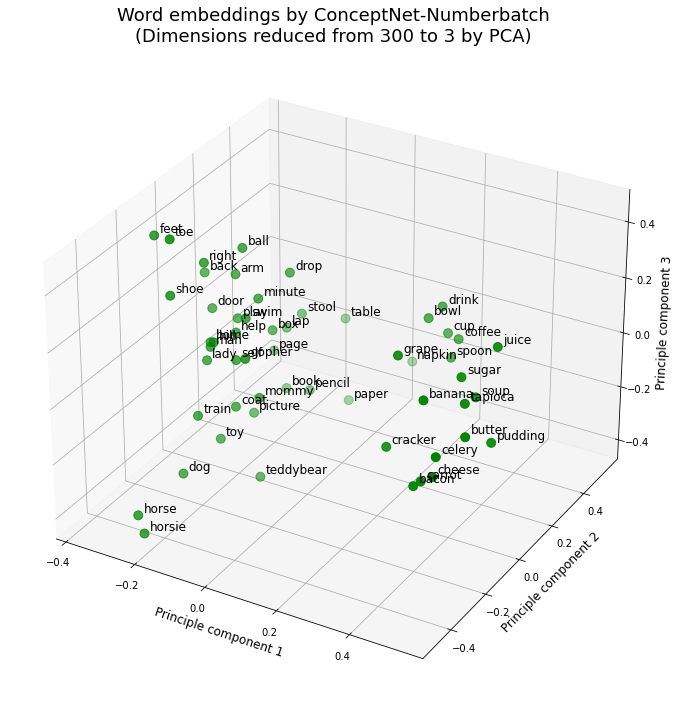

In [8]:
# Reduce dimension from 300 to 3 by PCA
pca = PCA(n_components=3)
result = pca.fit_transform(vocab_wv)

# Copy data for each dimension
X = result[:,0]
Y = result[:,1]
Z = result[:,2]

# Create figure with a 3D axis object
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

# 3D scatter plot
ax.scatter(X, Y, Z, facecolors='green', s=80)

# Add word labels
for x, y, z, word in zip(X, Y, Z, vocab):
    ax.text(x+0.01, y+0.01, z+0.01, word, size='12')
    
# Set axis labels and title
ax.set_xlabel('Principle component 1', size='12')
ax.set_ylabel('Principle component 2', size='12')
ax.set_zlabel('Principle component 3', size='12')
ax.set_title(('Word embeddings by ConceptNet-Numberbatch\n'
              '(Dimensions reduced from 300 to 3 by PCA)'),size='18')
ax.grid(color='black')

# Save figure
# plt.savefig('../reports/images/eve_vectors.svg', bbox_inches='tight', dpi=150)

plt.show()

### Step 4: Compute pairwise word similarity (cosine similarity) from word vectors

To construct a semantic network, we need to know the word similarity between every possible pair of words. As far as I know, Gensim can only compute cosine similarity between a pair of words one at a time. To compute pairwise cosine similarities across the entire word list, one has to do this manually by iterating the cosine similarity function of Gensim. Fortunately, there is a Scikit-learn function called `pairwise.cosine_similarity`, which computes pairwise cosine similarity and generates a matrix of cosine similarities from word vectors:

In [9]:
# compute pairwise cosine similarities
# from sklearn import metrics as skm  # imported already in document header
vocab_sim = skm.pairwise.cosine_similarity(vocab_wv)

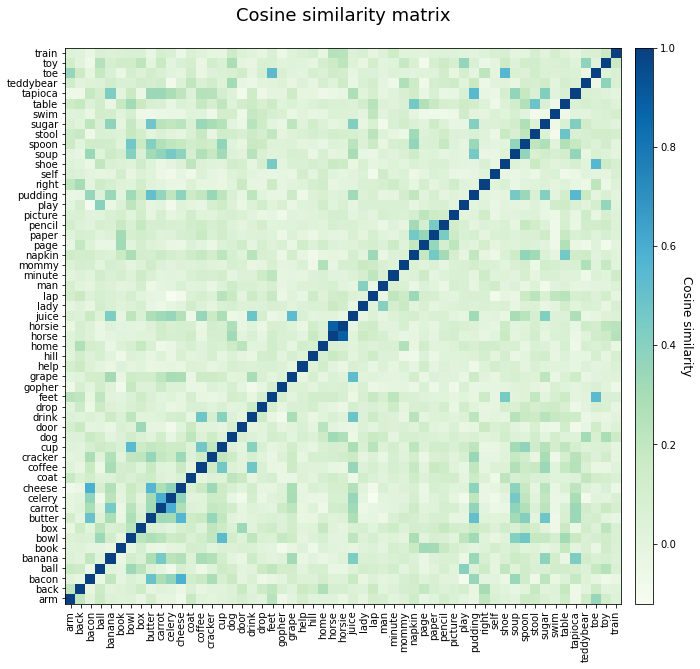

In [10]:
# Visualize the matrix of cosine similarities
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(vocab_sim, plt.cm.GnBu)

# Add color bar
cbar = plt.colorbar(pad=0.02, shrink=0.852, aspect=30)
cbar.set_label('Cosine similarity', size='12', rotation=-90, va="bottom")

# Set xtick labels
ax.xaxis.set_ticks(np.linspace(0, len(vocab_sim)-1, len(vocab_sim)))
ax.set_xticklabels(vocab, rotation='vertical')

# Set ytick labels
ax.yaxis.set_ticks(np.linspace(0, len(vocab_sim)-1, len(vocab_sim)))
ax.set_yticklabels(vocab)
ax.invert_yaxis()  # bottom-up yaxis for readability

plt.title('Cosine similarity matrix\n', size='18')

# Save figure
# plt.savefig('../reports/images/eve_sim_mat.svg', bbox_inches='tight', dpi=150)

plt.show()

### Step 5: Construct a semantic network using cosine similarities as the weights of edges

In a semantic network, words are the nodes and they can be linked by edges representing word similarity. There are many freely available tools to construct and analyze networks with nodes and edges. For this project, I chose to work with the NetworkX library because of its ease of use in Python and a large collection of algorithms for network analysis.

For the similarity threshold ($\varepsilon$), I will use the value 0.19 as suggested by 
>Amatuni and Bergelson (2017). Semantic Networks Generated from Early Linguistic Input. BioRxiv 157701; doi: https://doi.org/10.1101/157701.

In [11]:
# Create a NetworkX graph object
g = nx.Graph()

# Contruct the network from a word list and its similarity matrix
E = 0.19  # similarity threshold suggested in a child vocabulary study
for a, wordA in enumerate(vocab):
    for b, wordB in enumerate(vocab):
        # add an edge only when two words are different and similarity > E 
        if wordA != wordB and vocab_sim[a,b] > E:
            g.add_edge(wordA, wordB, weight=vocab_sim[a,b])
            
nx.info(g)

'Graph with 50 nodes and 168 edges'

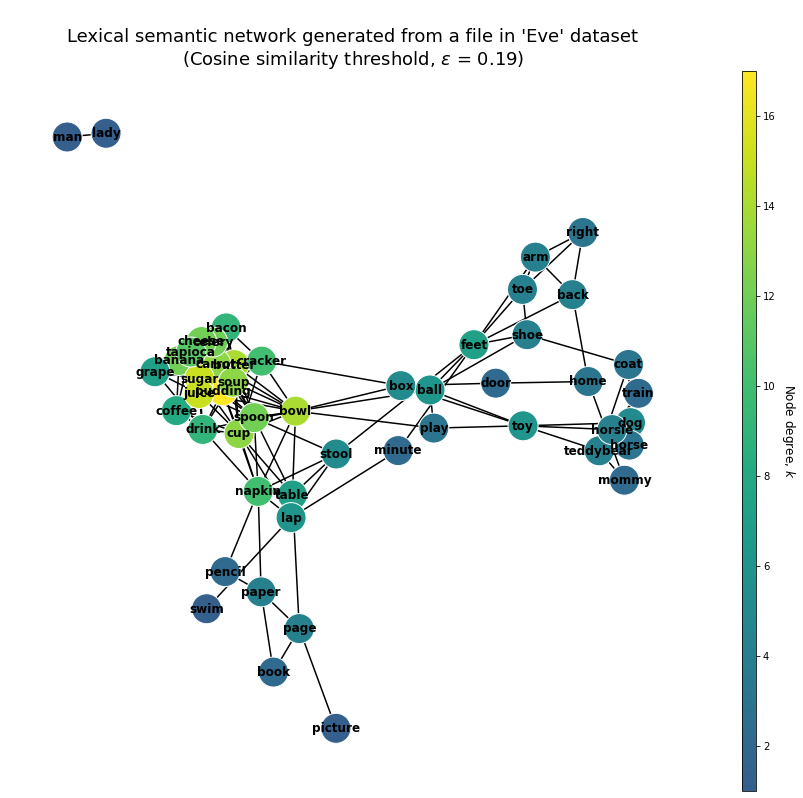

In [12]:
# Visualize the semantic netork built above
plt.figure(figsize=(12,10))

# set options for network graph
layout = nx.spring_layout(g, seed=0, k=0.2)          # set layout style
cmap = plt.cm.viridis                                # get matplotlib color map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       cmap, cmap(np.linspace(0.3,1,10)))            # use 70% of cmap's range
vmin = min(dict(g.degree()).values())                # for normalizing color
vmax = max(dict(g.degree()).values())                #  range to value range

options = {
    "width": 1.5,                                    # line width of edge
    "edge_color": "black",                           # color of edge
    "node_size": 900,
    "node_color": [deg for node,deg in g.degree()],  # link color to node degree
    "cmap": cmap,
    "vmin": vmin,                                    # "vmin" and "vmin" for
    "vmax": vmax,                                    #   value range
    "edgecolors": "white",                           # color of a node's edge  
    "with_labels": True,                             # turn on text labels
    "font_color": "black",
    "font_weight": "semibold",
    "font_size": "12"
}

# Plot
nx.draw(g, layout, **options)
plt.title(("\nLexical semantic network generated from a file in 'Eve' dataset\n"
           "(Cosine similarity threshold, $\epsilon$ = {})".format(E)), size='18')

# color bar
cbarmap = plt.cm.ScalarMappable(cmap=cmap)
cbarmap.set_clim(vmin, vmax)
cbar = plt.colorbar(cbarmap, aspect=50)
cbar.set_label('Node degree, $\it{k}$', size='12', rotation=-90, va="bottom")

# Save figure
# plt.savefig('../reports/images/eve_network.svg', bbox_inches='tight', dpi=150)

plt.show()

### Turning the above steps into a function

I will create a function for the above steps locally in this notebook because this will be the only document where the function will be used. Note that the function will not import the required Python packages nor the word vectors from ConceptNet-Numberbatch. They should be loaded separately before using the function.

In [13]:
def make_network(f_reader, participants='CHI', pos='n', E=0):
    vocab = get_vocab(f_reader, participants=participants, pos=pos)  # Get word list
    if not(vocab): return np.nan  # Check if vocab is empty
    vocab = [w for w in vocab if wordvec.has_index_for(w)] # Remove OOV words
    if not(vocab): return np.nan  # Check if vocab is empty
    vocab_wv = wordvec[vocab]  # Map each word to its word vector
    vocab_sim = skm.pairwise.cosine_similarity(vocab_wv)  # get cos similarity
    # Construct the network:
    g = nx.Graph()
    for a, wordA in enumerate(vocab):
        for b, wordB in enumerate(vocab):
            if wordA != wordB and vocab_sim[a,b] > E:
                g.add_edge(wordA, wordB, weight=vocab_sim[a,b])
    return g if g else np.nan  # Check if g is empty

# Test the function
g = make_network(eve[2], pos='n', E=0.19)
nx.info(g)

'Graph with 50 nodes and 168 edges'

---

# 3 Semantic network analysis

## 3.1 Characterizing semantic network

To quantify semantic network properties, I will use the following common metrics:
- number of nodes
- number of edges
- average degree (K)
- average shortest path length (L)
- average local clustering coefficient (C)

One thing we should consider when computing L and C is that, some semantic networks may contain disconnected components. For example, in Eve's semantic network, there are two disconnected components:

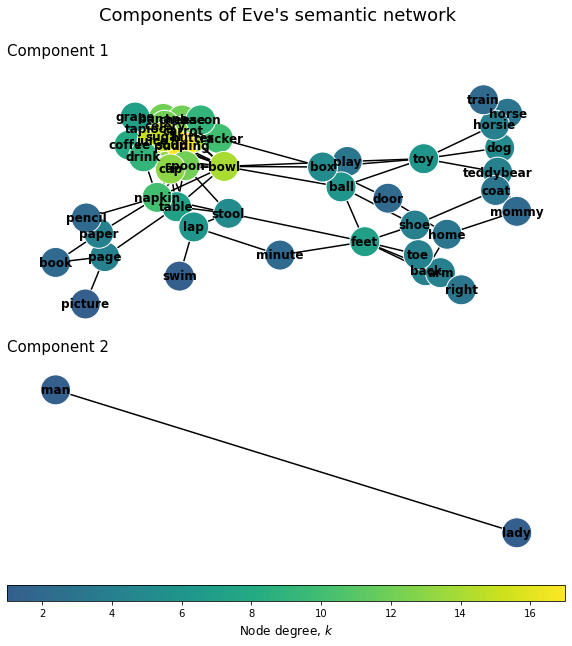

In [14]:
fig = plt.figure(figsize=(10,10))
n = nx.number_connected_components(g)
cmap = plt.cm.viridis                                # get matplotlib color map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       cmap, cmap(np.linspace(0.3,1,10)))            # use 70% of cmap's range
vmin = min(dict(g.degree()).values())                # for normalizing color
vmax = max(dict(g.degree()).values())                #  range to value range

for i, c in enumerate(nx.connected_components(g)):
    ax = fig.add_subplot(n,1,i+1)
    # set options for network graph
    layout = nx.spring_layout(g, seed=0, k=0.2)
    options = {
        "width": 1.5,
        "edge_color": "black",
        "node_size": 900,
        "node_color": [deg for node,deg in g.subgraph(c).degree()],
        "cmap": cmap,
        "vmin": vmin,
        "vmax": vmax,
        "edgecolors": "white",
        "with_labels": True,
        "font_color": "black",
        "font_weight": "semibold",
        "font_size": "12"
    }

    # Plot    
    nx.draw(g.subgraph(c), layout, **options)
    ax.set_title('Component {}\n'.format(i+1), size=15, loc='left')
    

# color bar
cbarmap = plt.cm.ScalarMappable(cmap=cmap)
cbarmap.set_clim(vmin, vmax)
cbar = plt.colorbar(cbarmap, location='bottom', aspect=35)
cbar.set_label('Node degree, $\it{k}$', size=12)

plt.suptitle('Components of Eve\'s semantic network', size=18)

# Save figure
# plt.savefig('../reports/images/net_components.svg', bbox_inches='tight', dpi=150)

plt.show()

Depending on the sizes (here: number of nodes) of a network's components, the value of C can vary a lot. Therefore, I will also look at C of the largest component (C<sub>0</sub>) in addition to the whole network's C. Besides, L cannot be computed from networks containing disconnected components because there are no paths between nodes of different components. Therefore, I will only compute the largest component's L (L<sub>0</sub>).

The following function compute all the network metrics mentioned above:

In [15]:
def get_net_stats(g):
    net_stats_dict = {}
    if not pd.isna(g):
        net_stats_dict['n_nodes'] = g.number_of_nodes()
        net_stats_dict['n_edges'] = g.number_of_edges()
        net_stats_dict['n_com']   = nx.number_connected_components(g)
        net_stats_dict['K']       = np.mean([deg for node,deg in g.degree()])
        net_stats_dict['C']       = nx.average_clustering(g)
        # Get largest component:
        g0 = g.subgraph(max(nx.connected_components(g), key=len))
        # Stats of largest component:
        net_stats_dict['C0']      = nx.average_clustering(g0)
        net_stats_dict['L0']      = nx.average_shortest_path_length(g0)
        net_stats_dict['D0']      = nx.diameter(g0)
    else:
        for stat in ['n_nodes','n_edges','n_com','K','C','C0','L0','D0']:
            net_stats_dict[stat]  = np.nan
    return net_stats_dict

As an example, here are the network properties of Eve's semantic network:

In [15]:
net_stats = pd.DataFrame(get_net_stats(g), index=[0])
net_stats

,n_nodes,n_edges,n_com,K,C,C0,L0,D0
0,50,168,2,6.72,0.481464,0.501525,3.118794,7


## 3.2 Constructing a semantic network from each CHAT file

Before analyzing the network properties, I will first construct a semantic network from each CHAT file. As mentioned previously, I will use 0.19 as the value for similarity threshold, $\varepsilon$. The network objects generated will be stored in a DataFrame:

In [35]:
# Read CHAT files into a reader object
print('Reading CHAT files...')
f = data_idx.file_path[(data_idx.ses!='unspecified') & 
                       (data_idx.age_m>=20) & 
                       (data_idx.age_m<=42)]
readers = pylangacq.Reader.from_files(f)
print('Done!')

# Construct semantic networks for all files and store them in a DataFrame
results = data_idx.loc[f.index]  # create a copy of filtered 'data_idx'
nets = [make_network(readers[i], pos='n', E=0.19) for i in range(len(f.index))]
results['net'] = nets  # store networks in a new column

Reading CHAT files...
Done!


Next, I will quantify the above semantic network properties and store the results in a DataFrame with the network objects:

In [36]:
print('Reading CHAT files...')

# Get network stats and store the values in the 'results' DataFrame
net_stats = pd.DataFrame()
for net in tqdm(results.net):
        df = pd.DataFrame(get_net_stats(net), index=[0])
        net_stats = net_stats.append(df)
net_stats.reset_index(inplace=True, drop=True)
results.reset_index(inplace=True, drop=True)
results = pd.concat([results,net_stats], axis=1)

print('Done!')
results.sample(3)

Reading CHAT files...


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [00:47<00:00,  7.73it/s]

Done!


,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,...,study_type,net,n_nodes,n_edges,n_com,K,C,C0,L0,D0
163,../data/childes/Brown/Sarah/030328.cha,Brown,1964.0,"{KEN, GRA, NAN, MOT, CHI}",Sarah,Brown_Sarah,1198,39.9,female,TD,...,"long, toyplay, TD","(puzzle, pieces, piece, alphabet, ball, box, h...",22.0,23.0,4.0,2.090909,0.318182,0.285714,3.406593,8.0
354,../data/childes/Post/She/011120.cha,Post,1989.0,"{CHI, MOT, SIB}",She,Post_She,710,23.7,female,TD,...,"long, toyplay, TD","(bunny, snowman, kangaroo, frogs, kitty, poppy...",51.0,217.0,1.0,8.509804,0.419020,0.419020,2.745098,8.0
20,../data/childes/Bates/Free20/ruth.cha,Bates,NaN,"{CHI, MOT}",Ruth,Bates_Ruth,600,20.0,female,TD,...,"cross, toyplay, TD","(chickie, baby)",2.0,1.0,1.0,1.000000,0.000000,0.000000,1.000000,1.0
113,../data/childes/Brown/Adam/030318.cha,Brown,1963.0,"{CHI, MOT, PAU, URS}",Adam,Brown_Adam,1188,39.6,male,TD,...,"long, toyplay, TD","(water, gas, cup, bottle, tea, fish, ducks, ta...",188.0,1296.0,1.0,13.787234,0.356002,0.356002,2.628570,6.0
165,../data/childes/Brown/Sarah/030409.cha,Brown,1964.0,"{CHI, KEN, MOT}",Sarah,Brown_Sarah,1209,40.3,female,TD,...,"long, toyplay, TD","(dog, cat, wheats, seeds, seed, grapes, sugar,...",25.0,39.0,3.0,3.120000,0.514667,0.554386,2.929825,6.0


## 3.3 Effects of semantic network size on network properties

As discussed in the last notebook, the curated dataset contains samples of different recording lengths. Therefore, semantic networks constructed from different samples are expected to have different sizes in terms of node number. For fair comparison, we should limit our analysis to networks of similar size. To examine how the network size influences the measurement of other network properties, I will look at the interaction between node number and L<sub>0</sub> , as well as between node number and C<sub>0</sub> .

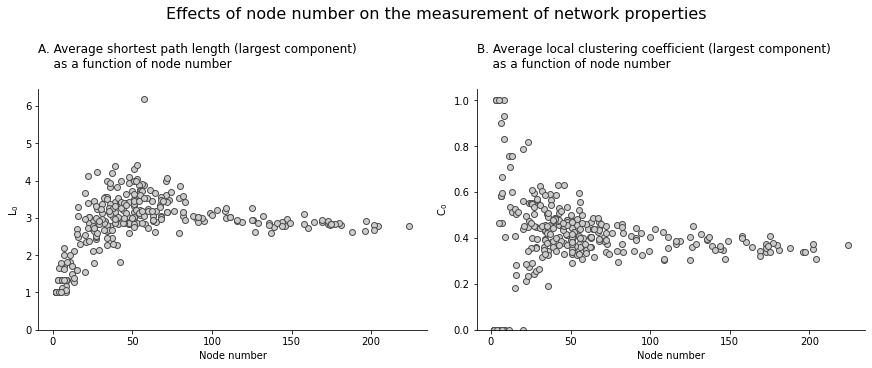

In [ ]:
# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['A','B']],
                              figsize=(12,5), facecolor='w',
                              constrained_layout=True)

# Plot 2 subplots
N = results.n_nodes
C0 = results.C0
L0 = results.L0
ax['A'].scatter(N, L0, facecolors='.8', edgecolors='.3')
ax['B'].scatter(N, C0, facecolors='.8', edgecolors='.3')
                                                           
# Set axis labels and subplot titles
for i in ['A', 'B']:
    ax[i].set_xlabel('Node number')
    ax[i].set_ylim(bottom=0)  # start at 0
    ax[i].spines[['top','right']].set_visible(False)  # remove top/right spines

ax['A'].set_ylabel('L$_{0}$')
ax['B'].set_ylabel('C$_{0}$')
ax['A'].set_title('\nA. Average shortest path length (largest component)\n'
                  '    as a function of node number\n', loc='left')
ax['B'].set_title('\nB. Average local clustering coefficient (largest component)\n'
                  '    as a function of node number\n', loc='left')

# Set figure title
fig.suptitle('Effects of node number on the measurement of network properties',fontsize=16)
plt.show()

The figure above shows an interesting non-linear interaction between node number and L<sub>0</sub> or C<sub>0</sub> : L<sub>0</sub> and C<sub>0</sub> increase as the network grows in size, but the increase stops and the value remains unchanged when the network size reaches at around 50 nodes. This is itself an intriguing phenomenon worth further investigation. Nevertheless, I will focus on comparing semantic networks across different SES groups in this project.

Since the values of L<sub>0</sub> and C<sub>0</sub> become relatively unaffected by node number in semantic networks containing more than 50 nodes, I will only include these networks in the following analysis.

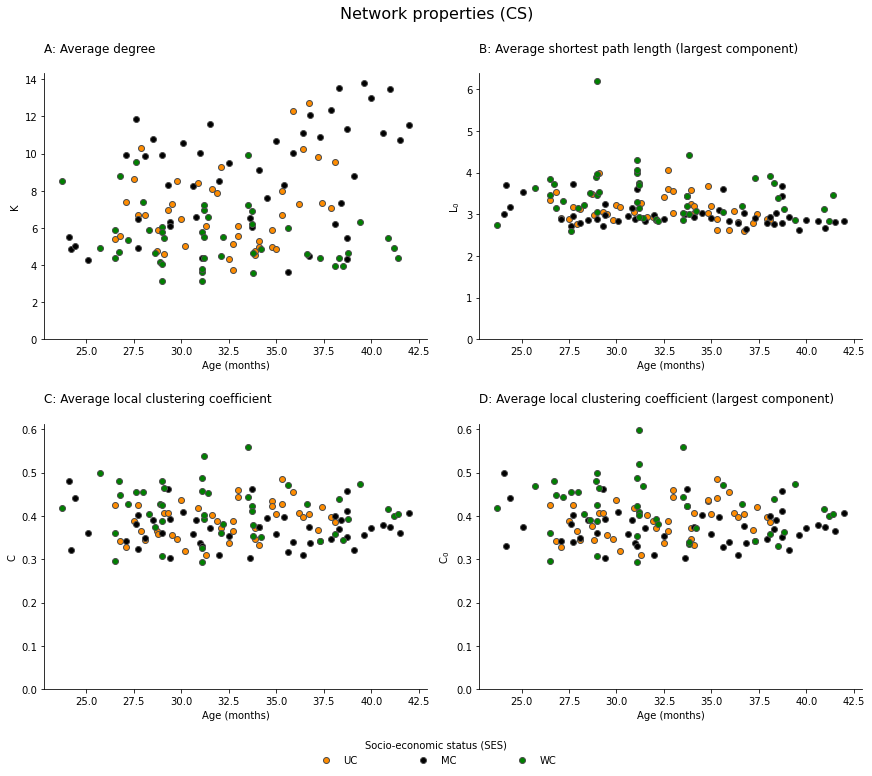

In [60]:
ses_list = ['UC', 'MC', 'WC']
stat_list = ['K', 'L0', 'C', 'C0']
label_dict = {'K': '\nA: Average degree\n',
              'L0':'\nB: Average shortest path length (largest component)\n',
              'C': '\nC: Average local clustering coefficient\n',
              'C0':'\nD: Average local clustering coefficient (largest component)\n'}
cmap = {'UC':'darkorange', 'MC':'k', 'WC':'g'}  # color map
n_thres = 50  # threshold: exclude samples with number of nodes < n_thres 

# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['K', 'L0'],
                              ['C','C0']],
                              figsize=(12,10), facecolor='w',
                              constrained_layout=True)

# Plot 4 subplots for each SES group
for s in ses_list:
    filters = results[(results.ses==s) &
                      (results.n_nodes>=n_thres)].index
    for v in stat_list:
        ax[v].scatter(results.age_m[filters], results[v][filters],
                      facecolors=cmap[s], edgecolors='.3')

# Set axis labels and subplot titles
for k,v in label_dict.items():
    ax[k].set_xlabel('Age (months)')
    ax[k].set_ylabel('{}{}'.format(k[0], '$_{0}$' if k[-1]=='0' else ''))
    ax[k].set_ylim(bottom=0)  # start at 0
    ax[k].set_title(v, loc='left')
    ax[k].spines[['top','right']].set_visible(False)  # remove top/right spines
    ax[k].sharex(ax['K'])  # all subplots use the same x-axis as subplot 'K'
ax['C'].sharey(ax['C0'])   # Subplot 'C' and 'C0' use the same y-axis 
# Set legend
fig.legend(ses_list, title='Socio-economic status (SES)', mode='expand', ncol=3,
           loc='lower left', bbox_to_anchor=(0.35,-0.07,0.3,0), edgecolor='none')

# Set figure title
fig.suptitle('Network properties (CS)',fontsize=16)
plt.show()

In [22]:
results_cds = data_idx.loc[f.index]
nets = [make_network(readers[i], participants='MOT', pos='n', E=0.19) 
        for i in range(len(f.index))]
results_cds['net'] = nets

net_stats = pd.DataFrame()
for net in tqdm(results_cds.net):
        df = pd.DataFrame(get_net_stats(net), index=[0])
        net_stats = net_stats.append(df)
net_stats.reset_index(inplace=True, drop=True)

results_cds.reset_index(inplace=True, drop=True)
results_cds = pd.concat([results_cds,net_stats], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:07<00:00,  5.48it/s]


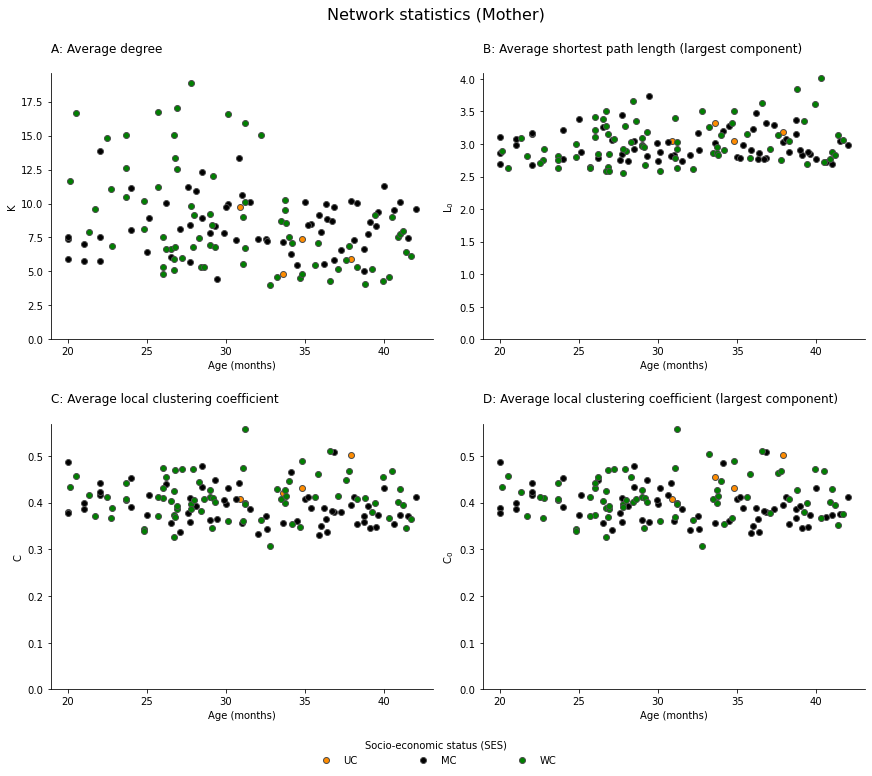

In [23]:
ses_list = ['UC', 'MC', 'WC']
stat_list = ['K', 'L0', 'C', 'C0']
label_dict = {'K': '\nA: Average degree\n',
              'L0':'\nB: Average shortest path length (largest component)\n',
              'C': '\nC: Average local clustering coefficient\n',
              'C0':'\nD: Average local clustering coefficient (largest component)\n'}
cmap = {'UC':'darkorange', 'MC':'k', 'WC':'g'}  # color map
n_thres = 50  # threshold: exclude samples with number of nodes < n_thres 

# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['K', 'L0'],
                              ['C','C0']],
                              figsize=(12,10), facecolor='w',
                              constrained_layout=True)

# Plot 4 subplots for each SES group
for s in ses_list:
    filters = results_cds[(results_cds.ses==s) &
                          (results_cds.n_nodes>=n_thres)].index
    for v in stat_list:
        ax[v].scatter(results_cds.age_m[filters], results_cds[v][filters],
                      facecolors=cmap[s], edgecolors='.3')

# Set axis labels and subplot titles
for k,v in label_dict.items():
    ax[k].set_xlabel('Age (months)')
    ax[k].set_ylabel('{}{}'.format(k[0], '$_{0}$' if k[-1]=='0' else ''))
    ax[k].set_ylim(bottom=0)  # start at 0
    ax[k].set_title(v, loc='left')
    ax[k].spines[['top','right']].set_visible(False)  # remove top/right spines
    ax[k].sharex(ax['K'])  # all subplots use the same x-axis as subplot 'K'
ax['C'].sharey(ax['C0'])   # Subplot 'C' and 'C0' use the same y-axis 
# Set legend
fig.legend(ses_list, title='Socio-economic status (SES)', mode='expand', ncol=3,
           loc='lower left', bbox_to_anchor=(0.35,-0.07,0.3,0), edgecolor='none')

# Set figure title
fig.suptitle("Network properties (Mother's CDS)",fontsize=16)
plt.show()

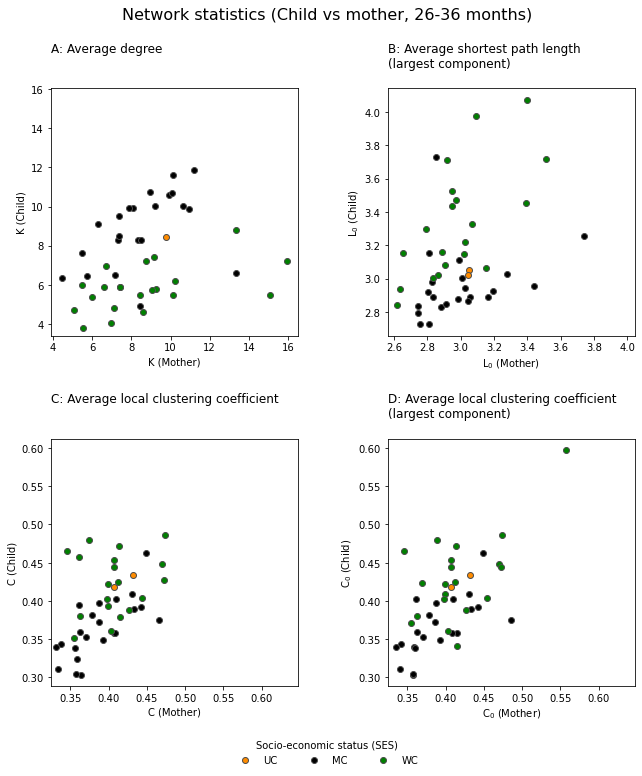

In [24]:
ses_list = ['UC', 'MC', 'WC']
stat_list = ['K', 'L0', 'C', 'C0']
label_dict = {'K': '\nA: Average degree\n\n',
              'L0':'\nB: Average shortest path length\n(largest component)\n',
              'C': '\nC: Average local clustering coefficient\n\n',
              'C0':'\nD: Average local clustering coefficient\n(largest component)\n'}
cmap = {'UC':'darkorange', 'MC':'k', 'WC':'g'}  # color map
n_thres = 50  # threshold: exclude samples with number of nodes < n_thres 

# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['K', 'L0'],
                              ['C','C0']],
                              figsize=(9.3,10), facecolor='w',
                              constrained_layout=True)

# Plot 4 subplots for each SES group
for s in ses_list:
    filters1 = results[(results.ses==s) &
                      (results.age_m>=26) & 
                      (results.age_m<=36) &
                      (results.n_nodes>=n_thres)].index
    filters2 = results_cds[(results_cds.ses==s) &
                      (results_cds.age_m>=26) & 
                      (results_cds.age_m<=36) &
                      (results_cds.n_nodes>=n_thres)].index
    # Get entries with both child speech and CDS passing the above filters:
    filters = list(set(filters1) & set(filters2))
    for v in stat_list:
        ax[v].scatter(results_cds[v][filters], results[v][filters],
                      facecolors=cmap[s], edgecolors='.3')

# Set axis labels and subplot titles
for k,v in label_dict.items():
    ax[k].set_xlabel('{}{} (Mother)'.format(k[0],'$_{0}$' if k[-1]=='0' else ''))
    ax[k].set_ylabel('{}{} (Child)'.format(k[0],'$_{0}$' if k[-1]=='0' else ''))
    ax[k].set_title(v, loc='left')
    ax[k].axis('square')
ax['C'].sharey(ax['C0'])   # Subplot 'C' and 'C0' use the same y-axis
ax['C'].sharex(ax['C0'])   # Subplot 'C' and 'C0' use the same x-axis 
# Set legend
fig.legend(ses_list, title='Socio-economic status (SES)', mode='expand', ncol=3,
           loc='lower left', bbox_to_anchor=(0.35,-0.07,0.3,0), edgecolor='none')

# Set figure title
fig.suptitle('Network statistics (Child vs mother, 26-36 months)',fontsize=16)
plt.show()

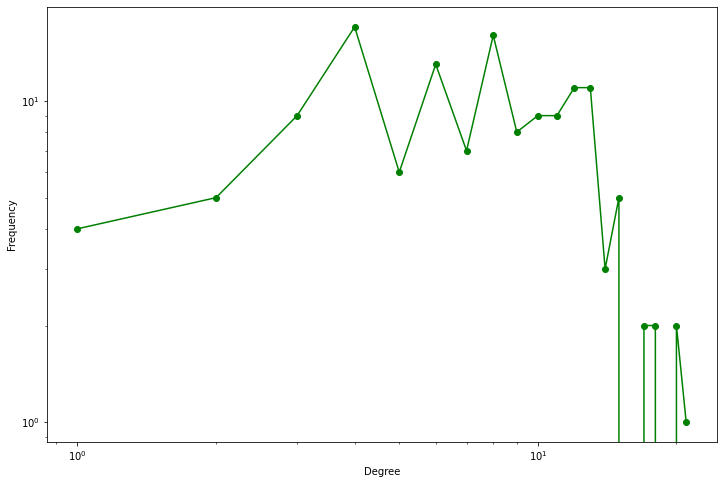

In [25]:
m = 1
degree_freq = nx.degree_histogram(net)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees[m:], degree_freq[m:],'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

(array([29., 11., 10.,  2.,  7.,  3.,  4.,  0.,  5., 10.,  8., 10.,  4.,
         9., 11.,  9.,  9.,  6., 11.,  7., 10.,  3., 17., 10.,  8.,  2.,
         4.,  9.,  2.,  7.,  1.,  7.,  1.,  1.,  2.,  1.,  5.,  0.,  1.,
         1.,  3.,  2.,  0.,  1.,  1.,  1.,  0.,  1.,  2.,  2.,  0.,  2.,
         1.,  0.,  0.,  3.,  1.,  1.,  1.,  0.,  3.,  1.,  1.,  2.,  1.,
         1.,  1.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  2.,  0.,  6.,
         1.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  3.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  2.  ,   4.22,   6.44,   8.66,  10.88,  13.1 ,  15.32,  17.54,
         19.76,  21.98,  24.2 ,  26.42,  28.64,  30.86,  33.08,  35.3 ,
         37.52,  39.74,  41.96,  44.18,  46.4 ,  48.62,  50.84,  53.06,
         55.28,  57.5 ,  59.72,  61.94,  64.16,  66.38,  68.6 ,  70.82,
         73.04,  75.26,  77.48,  79.7 ,  81.92,  84.14,  86.36,  88.58,
         90.8 ,  93.02,  95.24,  97.46,  99.68, 101.9 , 104.12, 106.34,
  

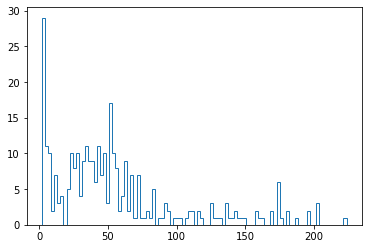

In [26]:
plt.hist(results.n_nodes, 100, histtype='step')

In [27]:
from etc.pittchat import get_wfreq as get_wfreq

In [28]:
freq = get_wfreq(readers, participants='CHI', pos='n')
rel_freq = { w : (f/sum(freq.values())) for w, f in freq.items() }


all_degs = dict()
for f in range(len(results)):
    if not pd.isna(results.net[f]):
        degs = dict(results.net[f].degree())
        for k,v in degs.items():
            if k in all_degs:
                all_degs[k].append(v)
            else:
                all_degs[k] = [v]

all_degs = {k:np.mean(all_degs[k]) for k,v in all_degs.items()}

# degs = {k: v for k, v in sorted(degs.items(), reverse=True, key=lambda x: x[1])}

In [29]:
df = pd.DataFrame()
for k,v in freq.items():
    if k in all_degs:
        freq_deg = pd.DataFrame({'freq':v, 'deg': all_degs[k]}, index=[0])
        df = pd.concat([df, freq_deg], ignore_index=True)
        

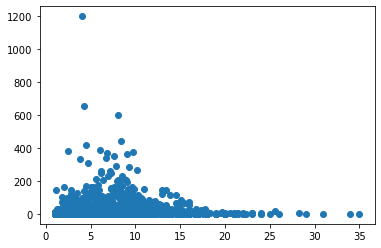

In [30]:
plt.scatter(df.deg, df.freq)

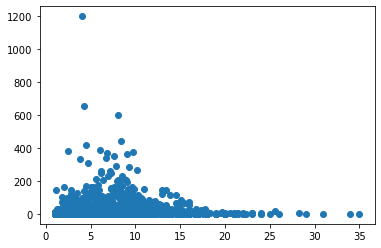

In [31]:
#cds
plt.scatter(df.deg, df.freq)

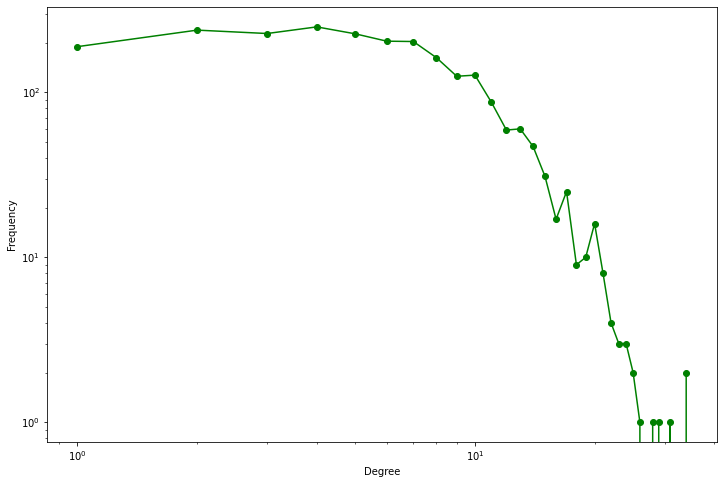

In [32]:
m = 1
counts = np.histogram(df.deg, bins=int(max(df.deg)-1))

degree_freq = counts[0]
degrees = counts[1][0:-1]

plt.figure(figsize=(12, 8)) 
plt.loglog(degrees, degree_freq,'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

KeyError: 'D0'

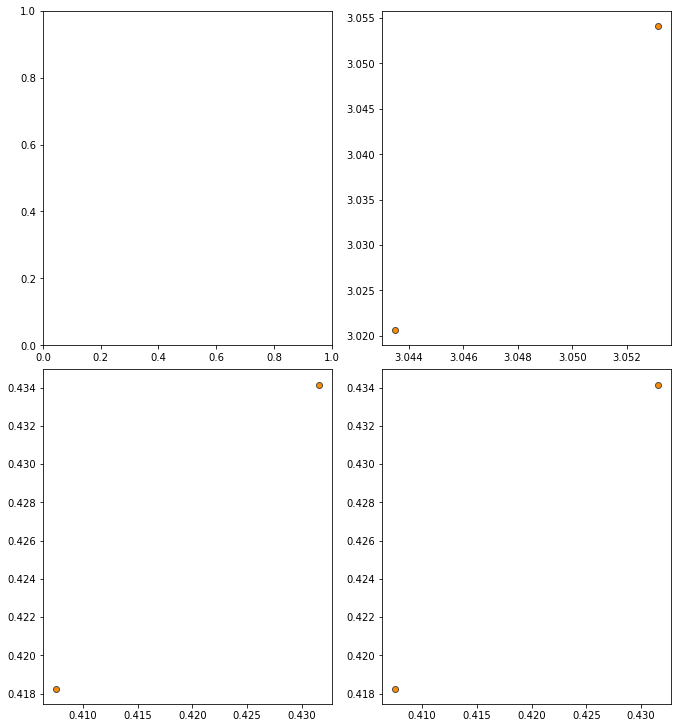

In [34]:
stat_list = ['L0', 'C', 'C0', 'D0']
label_dict = {'D0': 'A: Average degree\n',
              'L0':'B: Average shortest path length\n(largest component)',
              'C': '\nC: Average local clustering coefficient\n',
              'C0':'D: Average local clustering coefficient\n(largest component)'}
cmap = {'UC':'darkorange', 'MC':'k', 'WC':'g'}  # color map
n_thres = 50  # threshold: exclude samples with number of nodes < n_thres 

# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['K', 'L0'],
                              ['C','C0']],
                              figsize=(9.3,10), facecolor='w',
                              constrained_layout=True)

# Plot 4 subplots for each SES group
for s in ses_list:
    filters1 = results[(results.ses==s) &
                      (results.age_m>=26) & 
                      (results.age_m<=36) &
                      (results.n_nodes>=n_thres)].index
    filters2 = results_cds[(results_cds.ses==s) &
                      (results_cds.age_m>=26) & 
                      (results_cds.age_m<=36) &
                      (results_cds.n_nodes>=n_thres)].index
    # Get entries with both child speech and CDS passing the above filters:
    filters = list(set(filters1) & set(filters2))
    for v in stat_list:
        ax[v].scatter(results_cds[v][filters], results[v][filters],
                      facecolors=cmap[s], edgecolors='.3')

# Set axis labels and subplot titles
for k,v in label_dict.items():
    ax[k].set_xlabel('{}{} (Mother)'.format(k[0],'$_{0}$' if k[-1]=='0' else ''))
    ax[k].set_ylabel('{}{} (Child)'.format(k[0],'$_{0}$' if k[-1]=='0' else ''))
    ax[k].set_title(v, loc='left')
    ax[k].axis('square')
ax['C'].sharey(ax['C0'])   # Subplot 'C' and 'C0' use the same y-axis
ax['C'].sharex(ax['C0'])   # Subplot 'C' and 'C0' use the same x-axis 
# Set legend
fig.legend(ses_list, title='Socio-economic status (SES)', mode='expand', ncol=3,
           loc='lower left', bbox_to_anchor=(0.35,-0.07,0.3,0), edgecolor='none')

# Set figure title
fig.suptitle('Network statistics (Child vs mother, 26-36 months)\n',fontsize=16)
plt.show()

In [ ]:
# Visualize the semantic netork built above
plt.figure(figsize=(12,10))

# set options for network graph
layout = nx.spring_layout(g, seed=0, k=0.2)          # set layout style
cmap = plt.cm.gnuplot2                               # get matplotlib color map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       cmap, cmap(np.linspace(0.9,0.45,10)))         # use 45% of cmap's range
                                                     #   in reverse gradient
# Get min. and max. values of eccentricity of largest component
c0 = [c for c in nx.connected_components(g)][0]      # get largest component
g0 = g.subgraph(c0)
vmin = min(nx.eccentricity(g0).values())             # for normalizing color
vmax = max(nx.eccentricity(g0).values())             #   range to value range


options = {
    "width": 1.5,                                    # line width of edge
    "edge_color": "black",                           # color of edge
    "node_size": 900,
    "node_color": [ecc for ecc in nx.eccentricity(g0).values()],  # link color to node degree
    "cmap": cmap,
    "vmin": vmin,                                    # "vmin" and "vmin" for
    "vmax": vmax,                                    #   value range
    "edgecolors": "white",                           # color of a node's edge  
    "with_labels": True,                             # turn on text labels
    "font_color": "black",
    "font_weight": "semibold",
    "font_size": "12"
}

# Plot
nx.draw(g0, layout, **options)
plt.title(("\nLargest component ($\it{}_{}$) of \"Eve's\" semantic network\n"
           "(Diameter, $\it{}_{}$ = {})".format('g','0','D','0',vmax)), size='18')

# color bar
cbarmap = plt.cm.ScalarMappable(cmap=cmap)
cbarmap.set_clim(vmin, vmax)
ticks=np.linspace(vmin,vmax,vmax-vmin+1)
cbar = plt.colorbar(cbarmap, ticks=ticks, aspect=50)
cbar.set_label('Eccentricity, $\it{Ecc}$', size='12', rotation=-90, va="bottom")

# Save figure
# plt.savefig('../reports/images/eve_network_by_ecc.svg', bbox_inches='tight', dpi=150)
plt.show()